# 버전 설명 

LSTM Regression 활용 ?? 

데이터 로드 

In [ ]:
!unzip /content/drive/MyDrive/DataSet/전해탈지/Dataset.zip

라이브러리 모듈 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from glob import glob 
from tqdm import tqdm

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

# CSV 데이터 병합 

## csv 리스트 디렉토리 

In [4]:
csv_list_dir = glob('/content/data/*.csv')
csv_list_dir.sort()
csv_list_dir.remove( '/content/data/Error Lot list.csv',)

## input 데이터 로드 

In [5]:
def add_date(df,dir):
  date = dir[-14:-4]
  df['date'] = date
  return df 
  
#init 
dir = csv_list_dir[0]
df = pd.read_csv(dir)
df = add_date(df,dir)

for dir in csv_list_dir[1:]:
  temp_df = pd.read_csv(dir)
  temp_df = add_date(temp_df,dir)
  df = pd.concat([df,temp_df],axis=0)

## output 데이터 로드

In [6]:
error = pd.read_csv('/content/data/Error Lot list.csv')
error = error.fillna(0)
error['Date'] = error['Date'].apply(lambda x : x.replace('-','.')) # input 데이터랑 date 형태 통일 

## error 데이터 parsing 

In [7]:
df['error']=0

def add_error(df,error,index):
  date = error.iloc[index,:]['Date']
  LoT = error.iloc[index,:]['LoT']
  LoT2 = error.iloc[index,:]['LoT2']
  df.loc[(df['date']==date)&(df['Lot']==LoT),'error']=1
  df.loc[(df['date']==date)&(df['Lot']==LoT2),'error']=1
  return df
  
for index in range(len(error)):
  df = add_error(df,error,index)

15.0
15


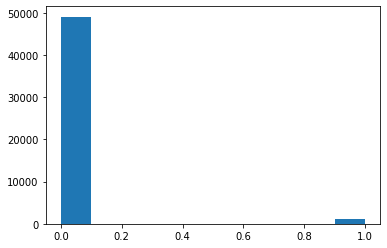

In [8]:
#정상적으로 입력 됬는지 확인 
print(len(df[df['error']==1])/69)
temp = np.array(error)[:,2:]
print(len(temp[temp!=0]))
plt.hist(df['error'])
plt.show()

In [ ]:
np.array(df).shape

(50094, 8)

# 전처리

## 편차 게산 

편차 계산을 위한 각 변수들 평균 계산 

In [9]:
columns = ['pH','Temp','Current']
mean_values = np.array(df[columns]).mean(axis=0).astype(np.int)
print('Ph = ' ,mean_values[0])
print('Temp = ', mean_values[1])
print('Current = ', mean_values[2])

Ph =  10
Temp =  45
Current =  7


In [10]:
def diff_cal(columns,values):
  if columns == 'pH':
    return_value = abs(10-values)
  if columns == 'Temp':
    return_value = abs(45-values)
  if columns == 'Current' :
    return_value = abs(7-values)
  return return_value

def time_change(value):
  import time
  import datetime
  s = value
  s = time.mktime(datetime.datetime.strptime(s, "%Y/%m/%d").timetuple())
  return s 

df['Current_diff'] = df['Current'].apply(lambda x : diff_cal('Current',x))
df['Temp_diff'] = df['Temp'].apply(lambda x : diff_cal('Temp',x))
df['pH_diff'] = df['pH'].apply(lambda x : diff_cal('pH',x))
df['Timestamp'] = df['date'].apply(lambda x : x.replace('.','/')).map(time_change)

df.head()

,Index,Lot,Time,pH,Temp,Current,date,error,Current_diff,Temp_diff,pH_diff,Timestamp
0,1,1,오후 4:29:15.0,10.37,42.87,7.34,2021.09.06,0,0.34,2.13,0.37,1.630886e+09
1,2,1,오후 4:29:20.0,10.90,42.70,8.26,2021.09.06,0,1.26,2.30,0.90,1.630886e+09
2,3,1,오후 4:29:25.0,9.61,42.37,8.46,2021.09.06,0,1.46,2.63,0.39,1.630886e+09
3,4,1,오후 4:29:30.0,10.32,45.85,8.04,2021.09.06,0,1.04,0.85,0.32,1.630886e+09
4,5,1,오후 4:29:35.0,10.36,44.18,7.23,2021.09.06,0,0.23,0.82,0.36,1.630886e+09


## 컬럼제거

In [44]:
# cols = ['pH','Temp','Current','Current_diff','Temp_diff','pH_diff','Timestamp','error']
cols = ['pH','Temp','Current','Current_diff','Temp_diff','pH_diff','error']
# cols = ['pH','Temp','Current','error']
input = np.array(df[cols])

input = input.reshape(-1,23,7)
output = [input[n+1,0,:] for n in range(2177)]
output = np.array(output)
input = input[:-1,:,:-1]

In [45]:
print(input.shape,output.shape)

(2177, 23, 6) (2177, 7)


## Train - test - valid 분할 

In [46]:
train_x = input[:1306,]
train_y = output[:1306,]

valid_x = input[1306:1800,]
valid_y = output[1306:1800,]

test_x = input[1800:,]
test_y = output[1800:,]

In [47]:
print(train_x.shape,train_y.shape)

(1306, 23, 6) (1306, 7)


## scaling

In [48]:
max = np.max(train_x,axis=0)
min = np.min(train_x,axis=0)

std = np.std(train_x,axis=0)
mean = np.mean(train_x,axis=0)

def scaling(df,max,min,mean,std,mode):
  if mode == 'minmax':
    scaled_df = (df-min)/(max-min)
    return scaled_df
  elif mode == 'std':
    scaled_df = (df-mean)/std
    return scaled_df

train_x = scaling(train_x,max,min,mean,std,'std')
test_x = scaling(test_x,max,min,mean,std,'std')

print(train_x.shape,train_y.shape)

(1306, 23, 6) (1306, 7)


#모델

In [ ]:
result = np.where(test_y==1)[0]
result

def check_recall(predicted,result):
  n = 0 
  target = []
  for i in predicted:
    if i in result:
      n+=1
      target.append(i)
    else:
      pass
  if n!= 0 :
    print('-------')
    print(f'predicted ={len(predicted)}')
    print(f'recall = {n/len(result)}')
    print(f'precision = {n/len(predicted)}')
    print(target,n)
    print('-------')
  else:
    pass

## LSTM REgression

In [ ]:
train_y_1= train_y[:,:-1]
train_y_2= train_y[:,-1]

In [ ]:
# for i in [120]:
for i in [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]:
  print(f'n_estimators={i}')
  print(f'rand={rand}')
  IF = IsolationForest(random_state=0,n_estimators=i,contamination = 'auto')
  IF.fit(train_x,train_y)
  y_ = IF.predict(test_x)
  predicted = np.where(y_==-1)[0]
  check_recall(predicted,result)
  print('\n')

In [61]:
from tensorflow.keras import layers 
from tensorflow import keras 
from tensorflow.keras.layers import Input, Dense, BatchNormalization,LSTM, Bidirectional
from tensorflow.keras import Model

In [ ]:
def make_model():
  input = Input((23,6))
  x = BatchNormalization()(input)
  x = Bidirectional(LSTM(32,activation = 'tanh'))(x)
  x = Dense(32, activation = 'relu')(x)
  x = BatchNormalization()(x)

  output_1 = Dense(32, activation = 'relu')(x)
  output_1 = BatchNormalization()(output_1)
  output_1 = Dense(16, activation = 'relu')(output_1)
  output_1 = BatchNormalization()(output_1)
  output_1 = Dense(6)(output_1)


  output_2 = Dense(32, activation = 'relu')(x)
  output_2 = BatchNormalization()(output_2)
  output_2 = Dense(16, activation = 'relu')(output_2)
  output_2 = BatchNormalization()(output_2)
  output_2 = Dense(2,activation = 'softmax')(output_2)

  model = Model(inputs = input,outputs = [output_1,output_2])
  return model
model = make_model()
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
history = model.fit(train_x,[train_y_1,train_y_2],verbose=1,batch_size=32,epochs=200)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [88]:
type(train_y_1)

numpy.ndarray

In [98]:
y_ = model.predict(train_x)
y_1 = y_[0]
y_2 = y_[1]

In [115]:
result_index = np.where(train_y_2==1)

(1306, 23, 6)

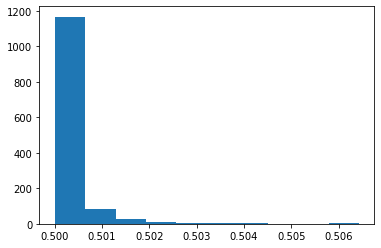

In [108]:
plt.hist(np.max(y_2,axis=1))
plt.show()